# Lab04: Decision Tree and Naive Bayes

- Student ID: 20127370
- Student name: Mai Quý Trung

**How to do your homework**


You will work directly on this notebook; the word `TODO` indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`).

Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`) Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**

- Decision Tree.
- Naive Bayes

### Import libs

In [1]:
using MLDatasets, Plots
using Statistics, Distributions
using MLJ
using Random
using DataFrames

### Load Iris dataset

In [2]:
X = MLDatasets.Iris.features()
X = transpose(X)
y = MLDatasets.Iris.labels()
y = replace(y, "Iris-setosa" => 0, "Iris-versicolor" => 1, "Iris-virginica" => 2)

┌ Warning: Iris.features() is deprecated, use `Iris().features` instead.
└ @ MLDatasets /Users/quytrungg/.julia/packages/MLDatasets/A3giY/src/datasets/misc/iris.jl:106
┌ Warning: Iris.labels() is deprecated, use `Iris().targets` instead.
└ @ MLDatasets /Users/quytrungg/.julia/packages/MLDatasets/A3giY/src/datasets/misc/iris.jl:109


150-element Vector{Any}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [3]:
Random.seed!(2022)

function train_test_split(X, y, test_size=0.33)
    """
    Parameters:
    -----------
    X (Vector<array>) : features array
    y (Vector<string>) : lables array
    test_size (float) : proportion of test dataset
    """
    n = size(X)[1]
    idx = shuffle(1:n)
    train_size = 1 - test_size
    train_idx = view(idx, 1:floor(Int, train_size*n))
    test_idx = view(idx, (floor(Int, train_size*n)+1):n)
    return X[train_idx,:], y[train_idx], X[test_idx,:], y[test_idx]
end

train_x, train_y, test_x, test_y = train_test_split(X, y, 0.33)

size(train_x), size(train_y), size(test_x), size(test_y)

((100, 4), (100,), (50, 4), (50,))

## 1. Decision Tree: Iterative Dichotomiser 3 (ID3)

### 1.1 Information Gain

Expected value of the self-information (entropy):

$$Entropy=-\sum_{x \in X}p(x) \log_{2} (p(x))

The entropy function gets the smallest value if there is a value of $p_i$ equal to 1, reaches the maximum value if all $ p_i $ are equal. These properties of the entropy function make it is an expression of the disorder, or randomness of a system, ...

In [4]:
function entropy(counts, n_samples)
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    sum = 0
    #TODO sum of entropy of each class
    for i in 1:length(counts)
        if counts[i] != 0
            probability = counts[i] / n_samples
            sum -= probability * log2(probability) 
        end
    end
    return sum
end

entropy (generic function with 1 method)

In [5]:
function entropy_of_one_division(division)
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = size(division, 1)
    n_classes = Set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for class in n_classes
        append!(counts, sum(division .== class))
    end 
    counts = Array(counts)

    entropy_val = entropy(counts, n_samples)
    return entropy_val, n_samples
end

function get_entropy(y_predict, y)
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = size(y,1)
    entropy_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    entropy_false, n_false = entropy_of_one_division(y[.~y_predict]) # right hand side entropy
    # overall entropy
    #TODO: s=
    s = @. n_true * 1.0 / n * entropy_true + n_false * 1.0 / n * entropy_false
    return s
end

get_entropy (generic function with 1 method)

The information gain of classifying information set D by attribute A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

At each node in ID3, an attribute is chosen if its information gain is highest compare to others.

All attributes of the Iris set are represented by continuous values. Therefore we need to represent them with discrete values. The simple way is to use a `cutoff` threshold to separate values of the data on each attribute into two part:` <cutoff` and `> = cutoff`.

To find the best `cutoff` for an attribute, we replace` cutoff` with its values then compute the entropy, best `cutoff` achieved when value of entropy is smallest  $ \left (\arg \min Entrophy_ {A} (D) \right) $.

### 1.2 Decision tree

In [6]:
function fit(X, y, node=Dict(), depth=0)
    """
    Parameter:
    -----------------
    X: training data
    y: label of training data
    ------------------
    return: node 
    
    node: each node represented by cutoff value and column index, value and children.
        - cutoff value is thresold where you divide your attribute
        - column index is your data attribute index
        - value of node is mean value of label indexes, 
        if a node is leaf all data samples will have same label
    
    Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
    """
    
    #Stop conditions
    
    #if all value of y are the same 
    if all(y.==y[1])
        return Dict("val"=>y[1])
    else 
        col_idx, cutoff, entropy = find_best_split_of_all(X, y)    # find one split given an information gain 
        y_left = y[X[:,col_idx] .< cutoff]
        y_right = y[X[:,col_idx] .>= cutoff]
        node = Dict("index_col"=>col_idx,
                    "cutoff"=>cutoff,
                    "val"=>mean(y),
                    "left"=> Any,
                    "right"=> Any)
        left = fit(X[X[:,col_idx] .< cutoff, :], y_left, Dict(), depth+1)
        right= fit(X[X[:,col_idx] .>= cutoff, :], y_right, Dict(), depth+1)
        push!(node, "left" => left)
        push!(node, "right" => right)
        depth += 1 
    end
    return node
end

function find_best_split_of_all(X, y)
    col_idx = nothing
    min_entropy = 1
    cutoff = nothing

    for i in 1:size(X,2)
        col_data = X[:,i]
        entropy, cur_cutoff = find_best_split(col_data, y)
        if entropy == 0                   #best entropy
            return i, cur_cutoff, entropy
        elseif entropy <= min_entropy
            min_entropy = entropy
            col_idx = i
            cutoff = cur_cutoff
        end
    end
    return col_idx, cutoff, min_entropy
end

function find_best_split(col_data, y)
    """ 
    Parameters:
    -------------
    col_data: data samples in column
    """
    min_entropy = 10
    cutoff = 0
    #Loop through col_data find cutoff where entropy is minimum
    
    for value in Set(col_data)
        y_predict = col_data .< value
        my_entropy = get_entropy(y_predict, y)
        #TODO
        # min entropy=?, cutoff=?
        if my_entropy .< min_entropy
            min_entropy = my_entropy
            cutoff = value
        end

    end
    return min_entropy, cutoff
end

find_best_split (generic function with 1 method)

In [7]:
function predict(data, tree)
    pred = []
    n_sample = size(data, 1)
    for i in 1:n_sample
        push!(pred, _predict(data[i,:], tree))
    end
    return pred
end

function _predict(row, tree)
    cur_layer = tree
    while haskey(cur_layer, "cutoff")
            if row[cur_layer["index_col"]] < cur_layer["cutoff"]
                cur_layer = cur_layer["left"]
            else
                cur_layer = cur_layer["right"]
            end
        end
    if !haskey(cur_layer, "cutoff")
        return get(cur_layer, "val", false)
    end
end

_predict (generic function with 1 method)

### 1.3 Classification on Iris Dataset

In [8]:
tree = fit(train_x, train_y)

Dict{String, Any} with 5 entries:
  "left"      => Dict("val"=>0)
  "cutoff"    => 1.0
  "right"     => Dict{String, Any}("left"=>Dict("val"=>1), "cutoff"=>4.8, "righ…
  "val"       => 0.92
  "index_col" => 4

In [9]:
#label of test_y[10]
print("Label of X_test[10]: ", test_y[10])

#update model and show histogram with X_test[10]:
print("\nOur histogram after update X_test[10]: ", _predict(test_x[10,:], tree))


Label of X_test[10]: 1


Our histogram after update X_test[10]: 1

In [10]:
pred=predict(test_x, tree)
print("Accuracy of your Gaussian Naive Bayes model:", accuracy(test_y,pred))


Accuracy of your Gaussian Naive Bayes model:0.94

## 2. Bayes Theorem

Bayes formulation
$$\begin{equation}
P\left(A|B\right)= \frac{P\left(B|A\right)P(A)}{P(B)}
\end{equation}$$

If $B$ is our data $\mathcal{D}$, $A$ and $w$ are parameters we need to estimate:

$$ \begin{align}
    \underbrace{P(w|\mathcal{D})}_{Posterior}= \dfrac{1}{\underbrace{P(\mathcal{D})}_{Normalization}} \overbrace{P(\mathcal{D}|w)}^{\text{Likelihood}} \overbrace{P(w)}^{Prior}
    \end{align}
$$

#### Naive Bayes
To make it simple, it is often assumed that the components of the $D$ random variable (or the features of the $D$ data) are independent with each other, if $w$ is known. It mean:

$$P(\mathcal{D}|w)= \prod^{d}_{i=1}P\left(x_i|w\right)$$

- $d$: number of features



### 2.1. Probability Density Function

In [11]:
#virtual function
# function likelihood(_mean=nothing, _std=nothing ,data=nothing, hypo=nothing)
#     # We will implement it later
# end

#update histogram for new data 
function update(_hist, _mean, _std, data)
    """
    P(hypo/data)=P(data/hypo)*P(hypo)*(1/P(data))
    """
    hist = copy(_hist)

    #Likelihood * Prior 
    #TODO
    for hypo in keys(hist)
        #hist[hypo]=?
        hist[hypo] = likelihood(_mean, _std, data, hypo) * hist[hypo]
    end    

    #Normalization
    #TODO: s=P(data)
    s = 0
    for hypo in keys(hist)
        #s=?
        s += hist[hypo]
    end    
    
    for hypo in keys(hist)
        hist[hypo] = hist[hypo]/s
    end
    return hist
end
    

function maxHypo(hist)
    #find the hypothesis with maximum probability from hist
    #TODO
    max = reduce((x, y) -> hist[x] ≥ hist[y] ? x : y, keys(hist))

    return max
end
 



maxHypo (generic function with 1 method)

### 2.2 Classification on Iris Dataset

#### Gaussian Naive Bayes

- Naive Bayes can be extended to use on continuous data, most commonly by using a normal distribution (Gaussian distribution).

- This extension called Gaussian Naive Bayes. Other functions can be used to estimate data distribution, but Gauss (or the normal distribution) is the easiest to work with since we only need to estimate the mean and standard deviation from the training data.

#### Define Gauss function

$$ f\left(x;\mu,\sigma \right)= \dfrac{1}{\sigma \sqrt{2\pi}} \exp\left({-\dfrac{(x-\mu)^2}{2 \sigma^2}}\right) $$

In [12]:
function Gauss(std, mean, x)
    #Compute the Gaussian probability distribution function for x
    #TODO 
    gauss = 1.0 / (std * sqrt(2 * 3.14))
    gauss *= (exp(-((x - mean) ^ 2) / (2 * std ^ 2)))
    return gauss
end


Gauss (generic function with 1 method)

In [18]:
function likelihood(_mean=nothing, _std=nothing ,data=nothing, hypo=nothing)
    """
    Returns: res=P(data/hypo)
    -----------------
    Naive bayes:
        Atributes are assumed to be conditionally independent given the class value.
    """

    std=_std[hypo]
    mean=_mean[hypo]
    res=1
    #TODO
    #res=res*P(x1/hypo)*P(x2/hypo)...
    for i in 1:length(data)
        res *= Gauss(std[i], mean[i], data[i])
    end
    return res     
end

function fit(X, y, _std=nothing, _mean=nothing, _hist=nothing)
    """Parameters:
    X: training data
    y: labels of training data
    """
    n=size(X,1)
    
    hist=Dict()
    mean=Dict()
    std=Dict()
    
    #separate  dataset into rows by class
    for hypo in Set(y)
        #rows have hypo label
        #TODO rows=
        rows = X[y .== hypo, :]

        #histogram for each hypo
        #TODO probability=?
        probability = length(rows) / n
        hist[hypo]=probability

        #Each hypothesis represented by its mean and standard derivation
        """mean and standard derivation should be calculated for each column (or each attribute)"""
        #TODO mean[hypo]=?, std[hypo]=?
        mean[hypo] = Statistics.mean(X[y .== hypo, :], dims=1)
        std[hypo] = Statistics.std(X[y .== hypo, :], dims=1)
        
    end
    _mean=mean
    _std=std
    _hist=hist
    return _hist, _mean, _std
end

function plot_pdf(_hist)
    f = Plots.bar(_hist, kind="bar", show=true)
    display(f)
end

function _predict(_hist, _mean, _std, data, plot=true)
    """
    Predict label for only 1 data sample
    ------------
    Parameters:
    data: data sample
    plot: True: draw histogram after update new record
    -----------
    return: label of data
    """
    hist = update(_hist, _mean, _std, data)
    if (plot == true)
        plot_pdf(hist)
    end
    return maxHypo(hist)
end


function predict(_hist, _mean, _std, data)
    """Parameters:
    Data: test data
    ----------
    return labels of test data
    """
    pred=[]
    n_sample = size(data, 1)
    for i in 1:n_sample
        push!(pred, _predict(_hist, _mean, _std, data[i,:]))
    end
    return pred
end    

predict (generic function with 2 methods)

#### Show histogram of training data

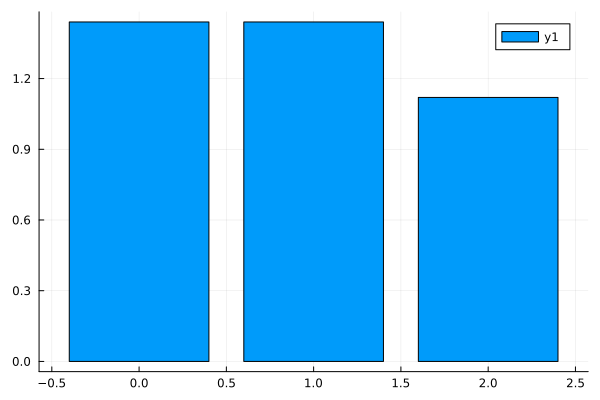

In [19]:
_hist, _mean, _std = fit(train_x, train_y)
plot_pdf(_hist)

#### Test with 1 data record

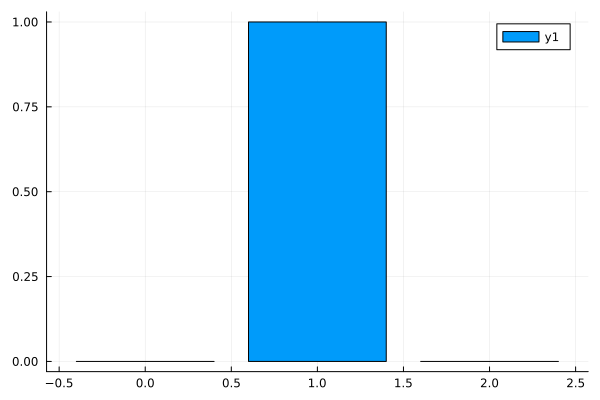

Label of X_test[10]: 1


Our histogram after update X_test[10]: 1

In [20]:
#label of test_y[10]
print("Label of X_test[10]: ", test_y[10])

#update model and show histogram with X_test[10]:
print("\nOur histogram after update X_test[10]: ", _predict(_hist, _mean, _std, test_x[10,:]))


#### Evaluate your Gaussian Naive Bayes model

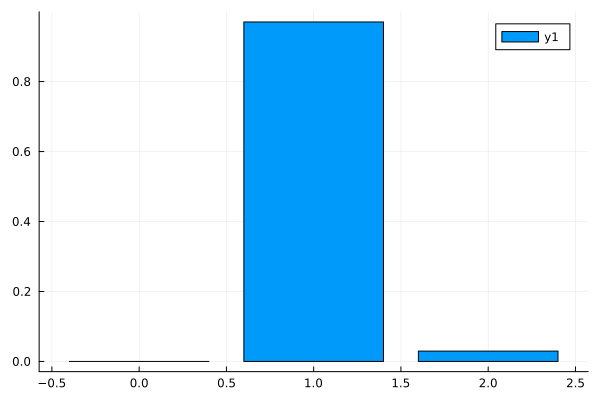

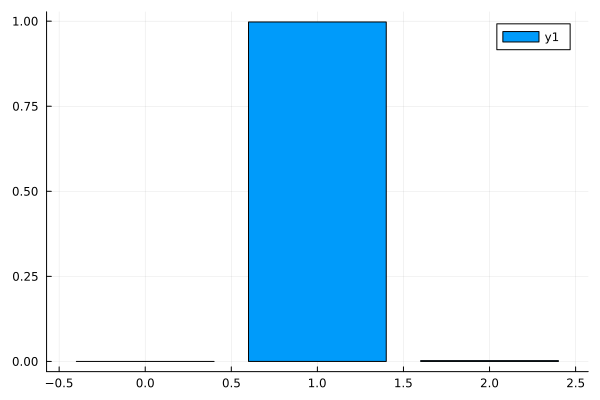

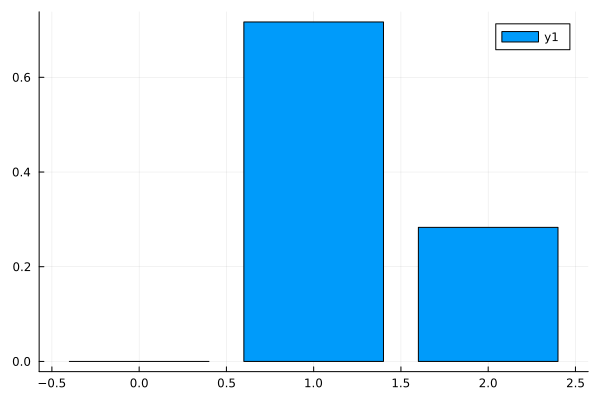

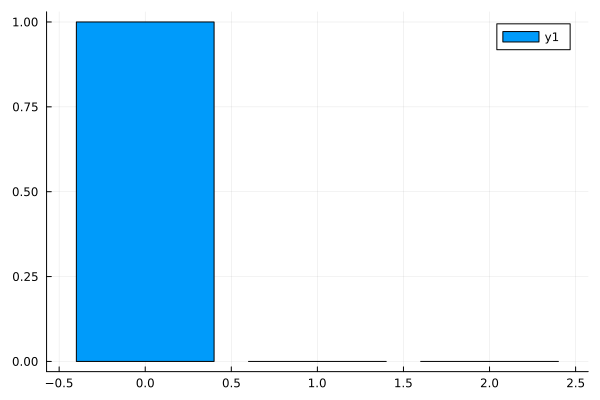

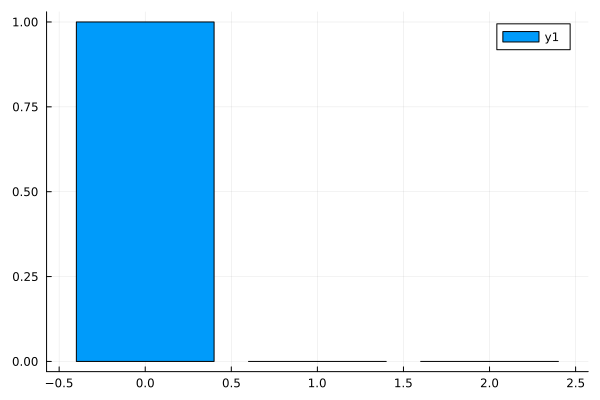

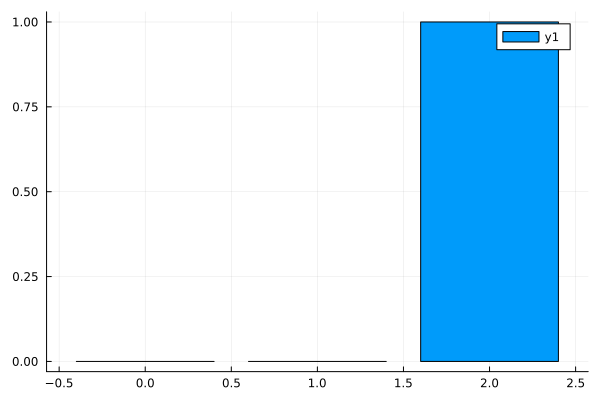

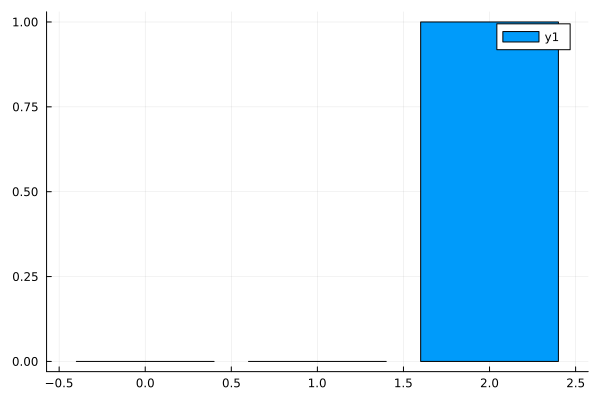

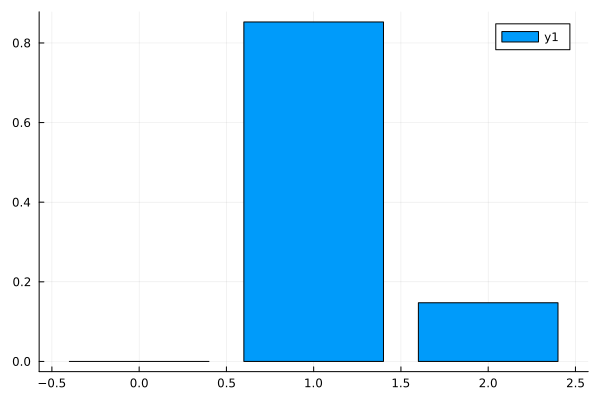

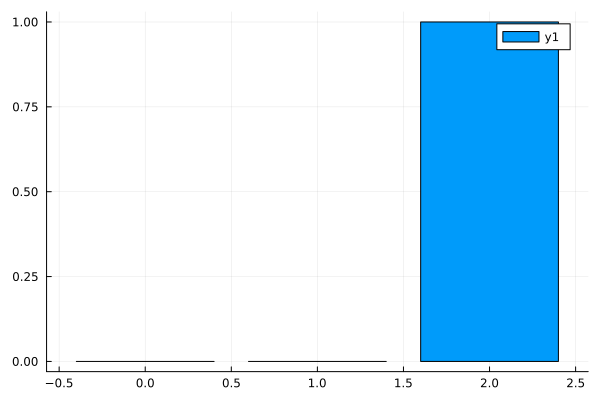

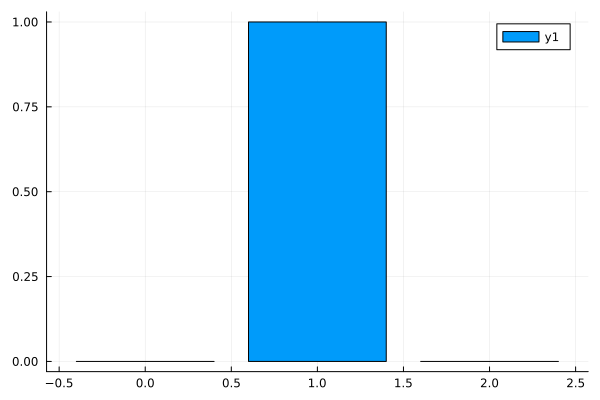

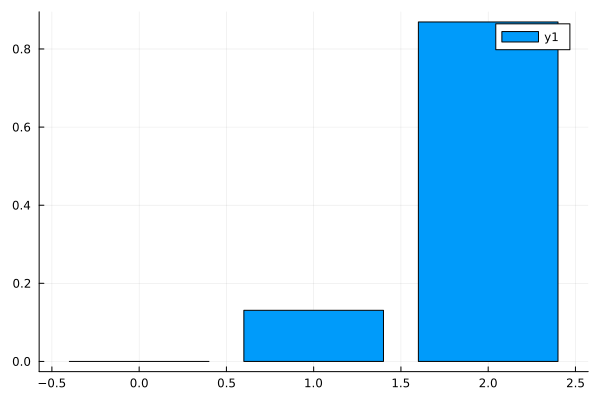

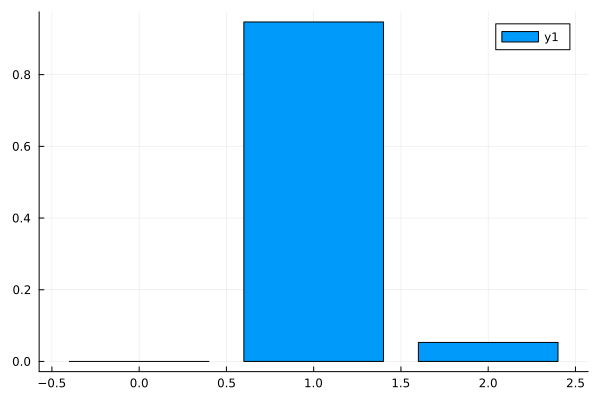

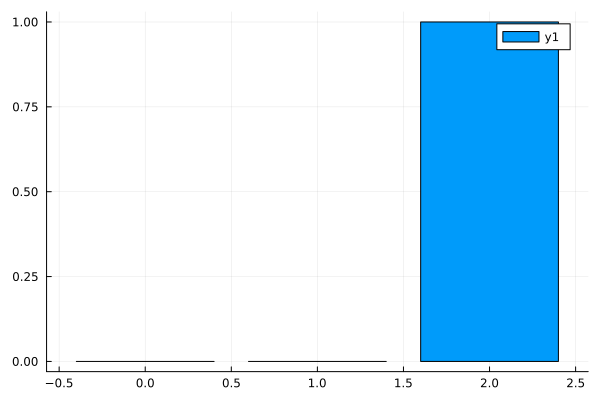

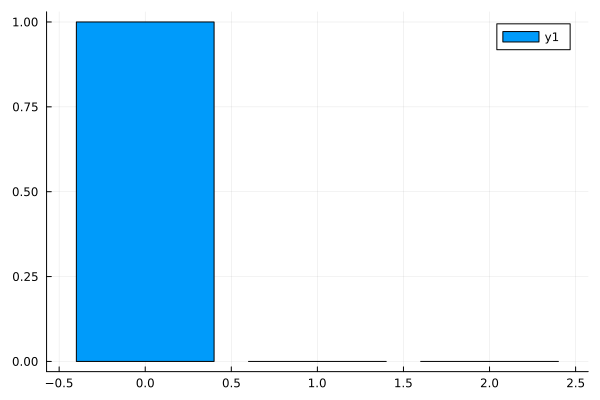

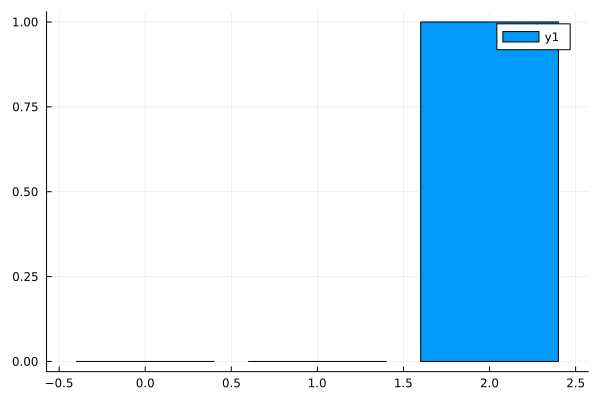

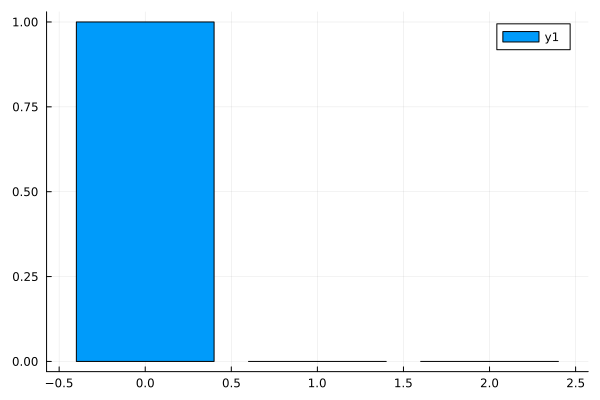

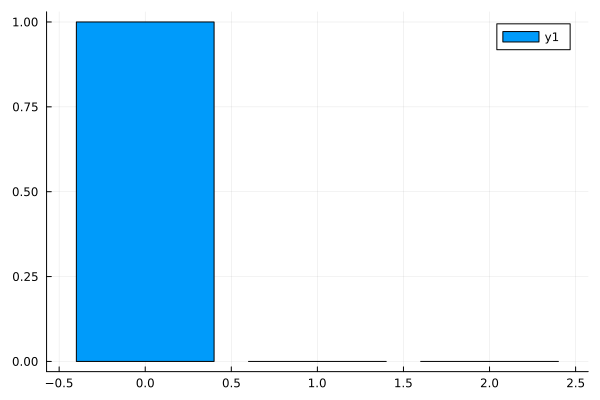

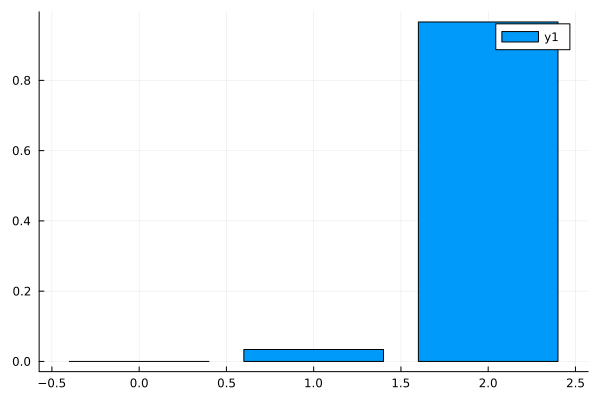

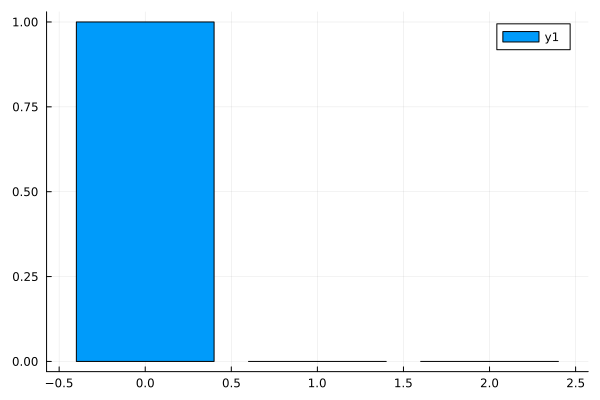

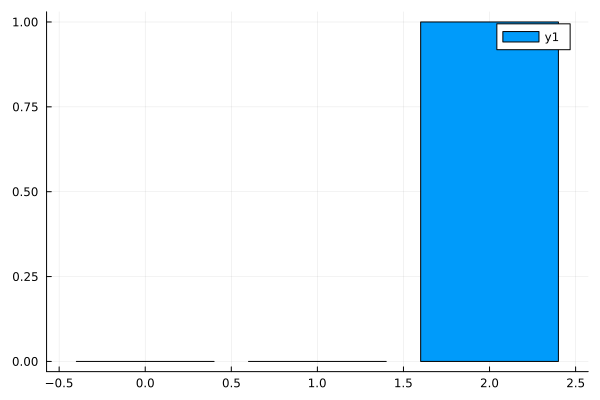

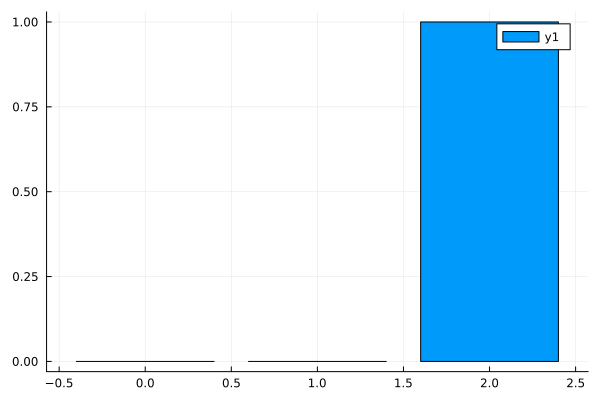

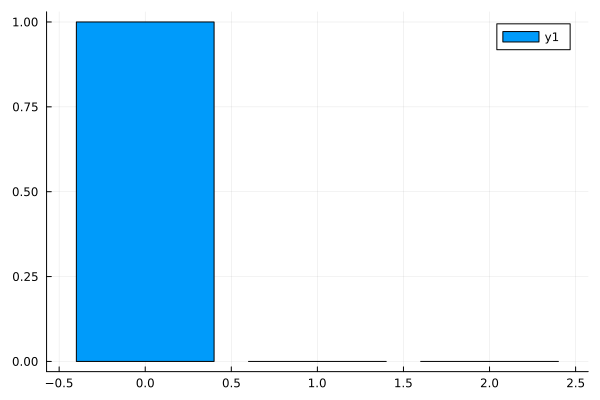

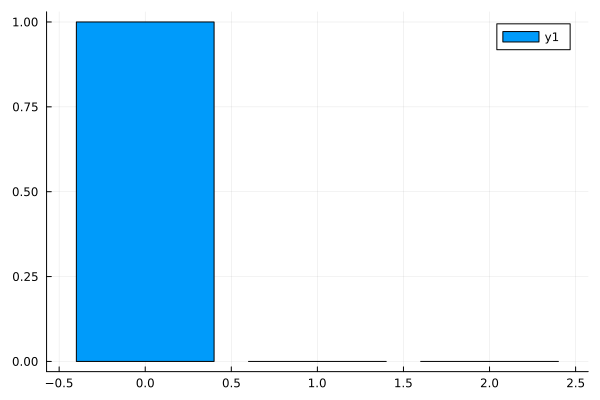

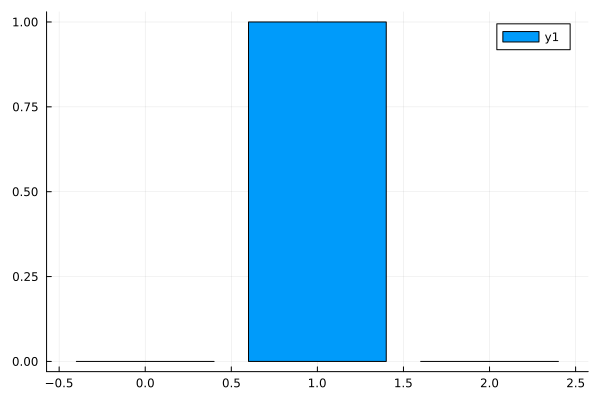

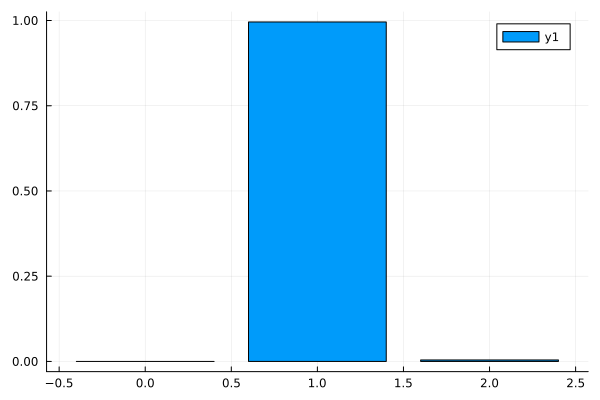

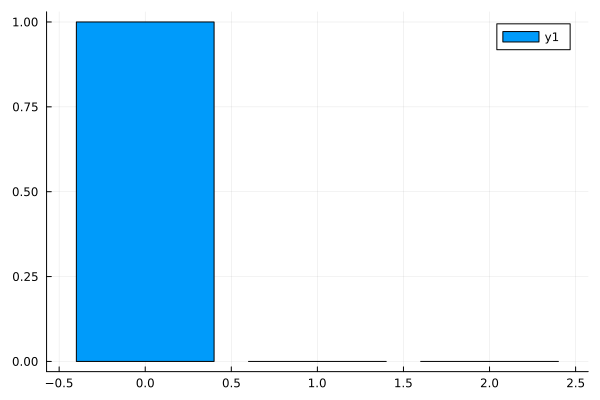

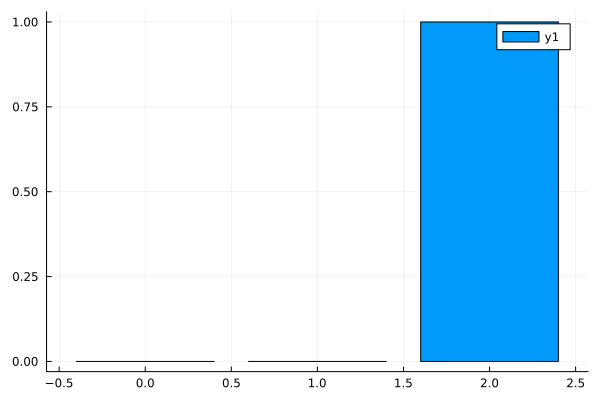

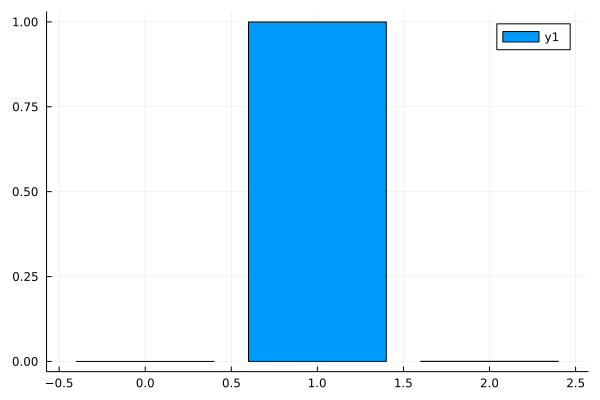

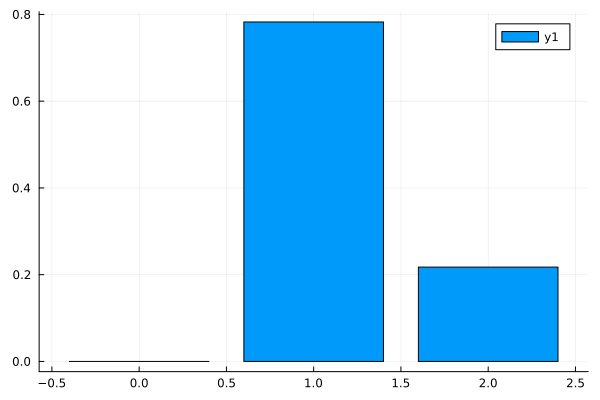

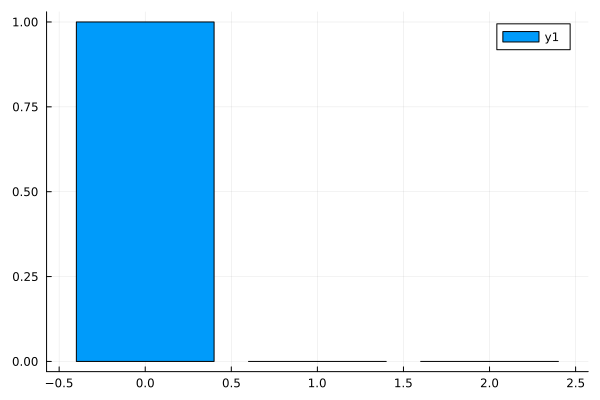

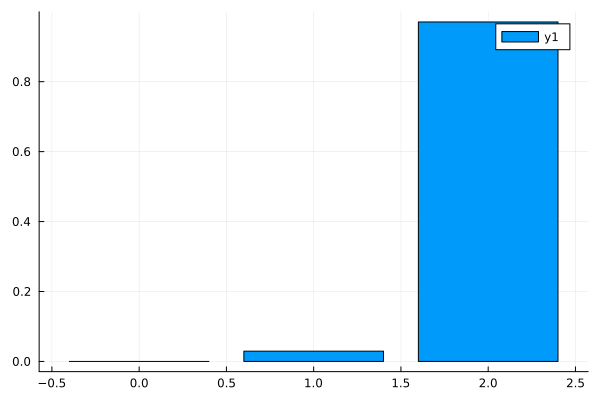

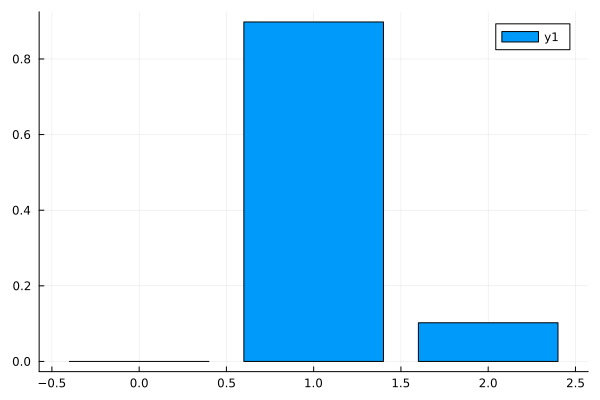

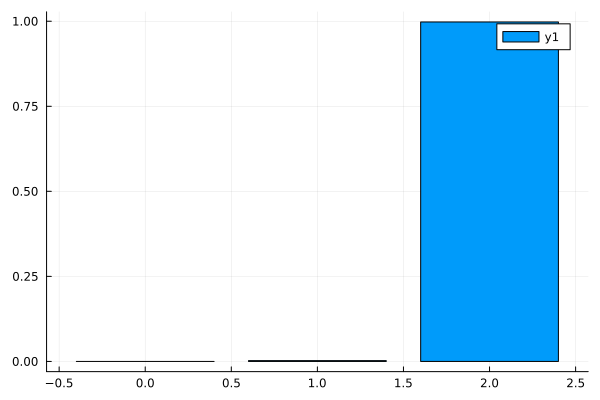

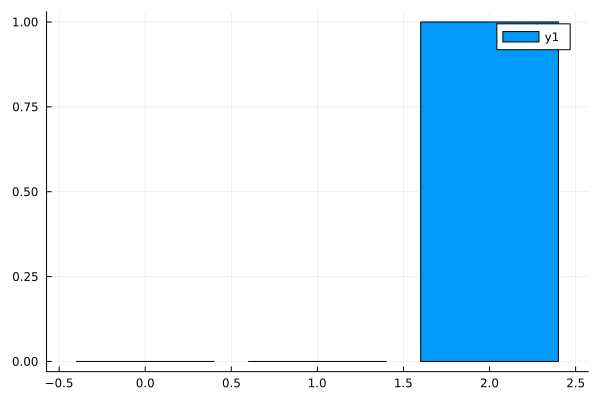

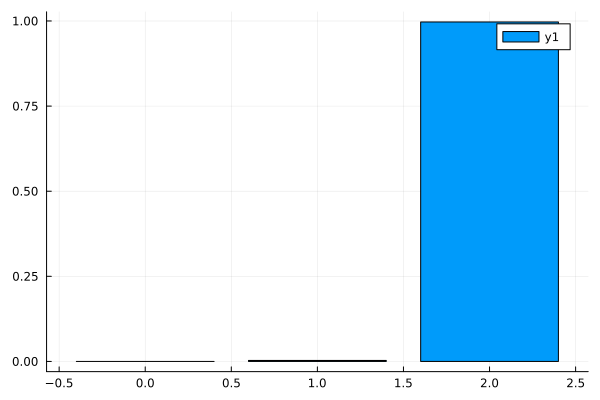

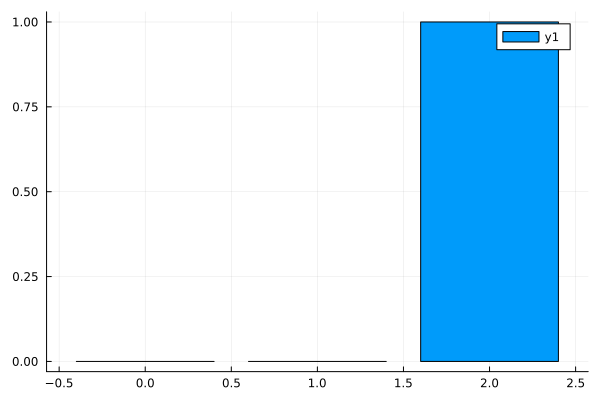

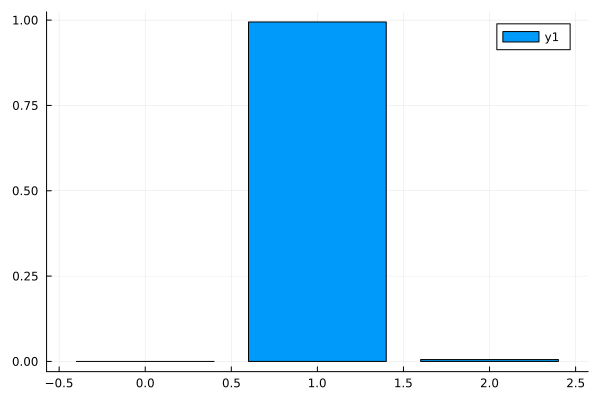

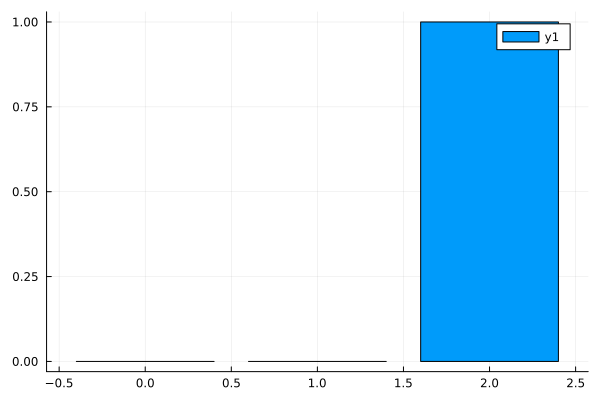

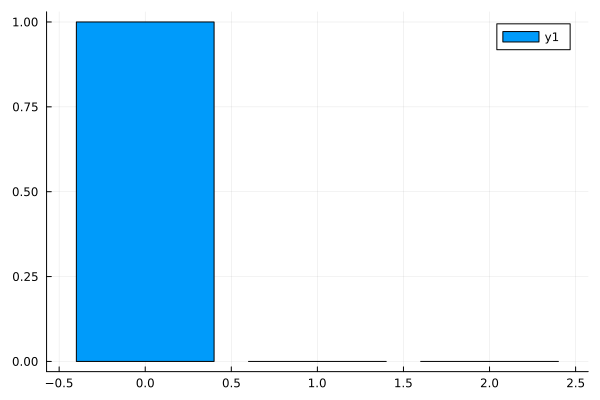

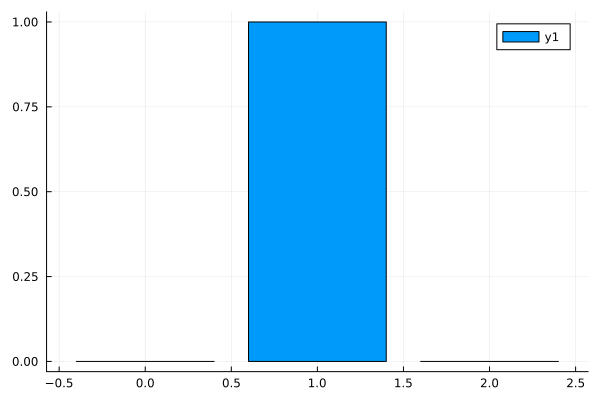

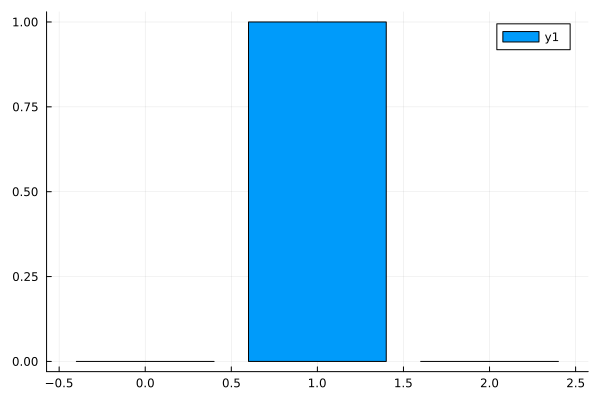

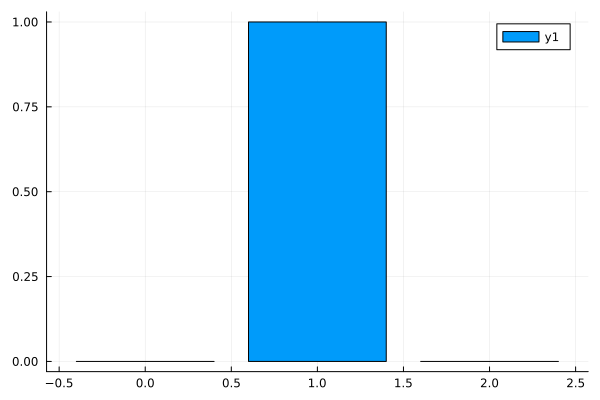

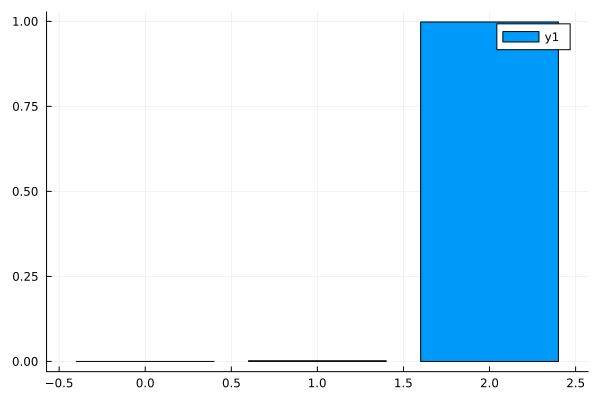

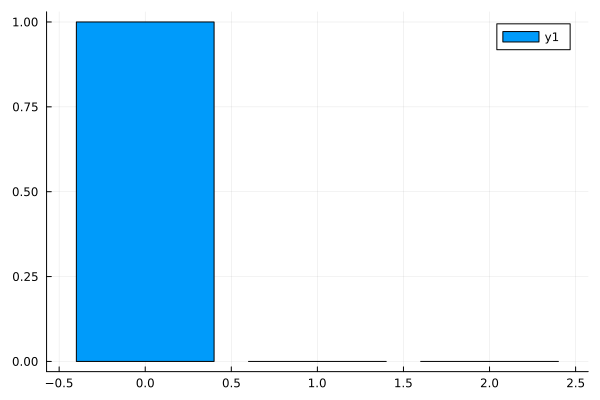

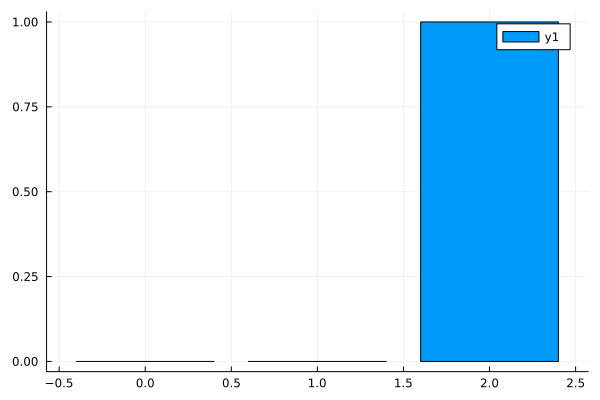

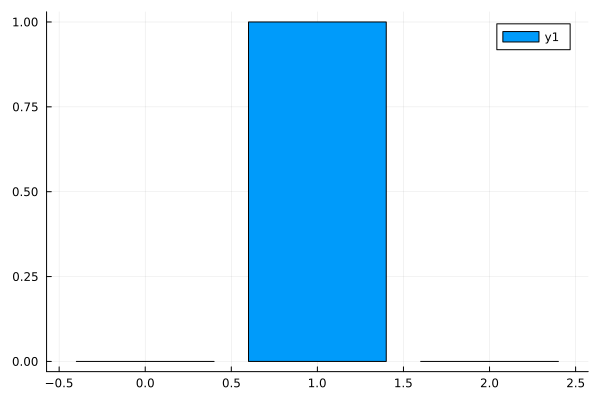

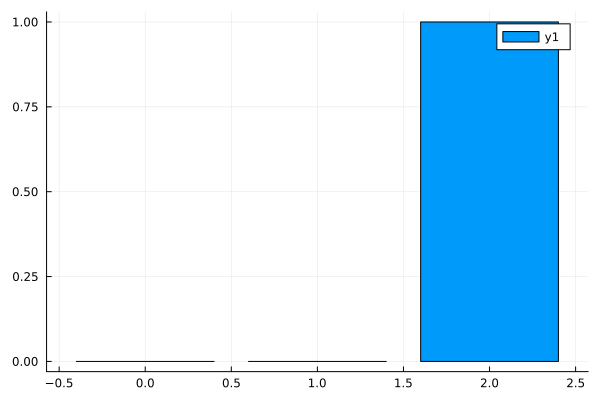

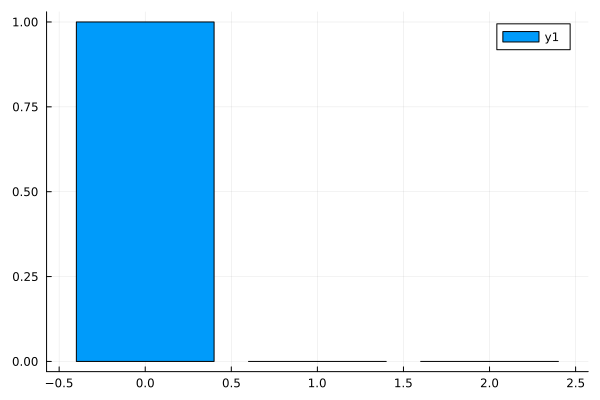

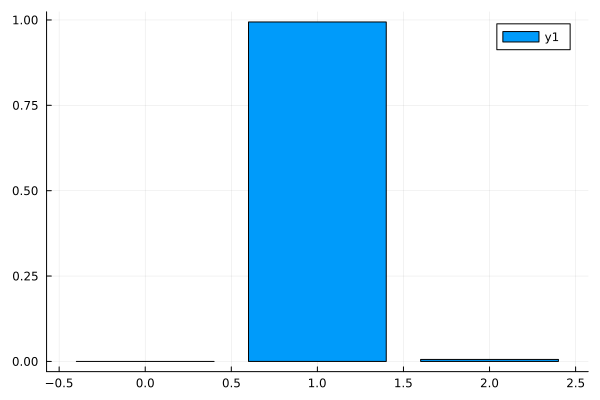

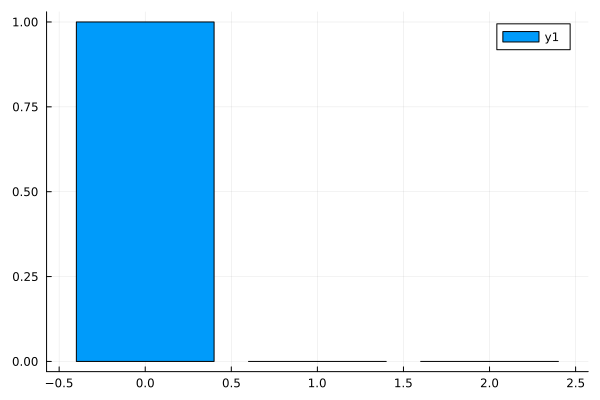

Accuracy of your Gaussian Naive Bayes model:0.94

In [16]:
pred=predict(_hist, _mean, _std, test_x)
print("Accuracy of your Gaussian Naive Bayes model:", accuracy(test_y,pred))

**TODO**: F1, Recall and Precision report

In [21]:
p = multiclass_precision(test_y, pred)
r = multiclass_recall(test_y, pred)
f1 = 2*p*r/(p + r)
println("Recall of the Gaussian Naive Bayes model: $p")
println("Precision of the Gaussian Naive Bayes model: $r")
println("F1 score of the Gaussian Naive Bayes model: $f1")

Recall of the Gaussian Naive Bayes model: 0.9545454545454546
Precision of the Gaussian Naive Bayes model: 0.9411764705882352
F1 score of the Gaussian Naive Bayes model: 0.9478138222849083


Comment: Both recall and precision score from the Gaussian Naive Bayes model are high, making the F1 score is also high with $\approx 95\% $